# LMA-HMM on simulated data (*simulations based on observed data*)
This notebook showcases practical applications on simulated data.

## Importing Libraries
We start by importing the necessary libraries for the operations ahead.

In [1]:
import os
os.chdir('../../')

from inference_mahmm import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## Data Simulation and Visualization

In a first step, we simulate the Markov chain of observations $Y$ governed by the hidden Markov chain $X$. 

### Choosing the Parameters of the Model

We set up parameters for the *L-Moving Average Hidden Markov Model* (LMA-HMM) with $K$ states and $L$ moving average component:
* `ν`: The initial probabilities of being in each state.
* `Q`: The transition probabilities between states.
* `M`: The means of the Gaussian distributions for each state.
* `Σ`: The standard deviations of the Gaussian distributions for each state.
* `T`: The number of time steps.
* `K`: The number of states.
* `L`: The moving average depth.

Model parameters are chosen according to actual observed data, in order to obtain a realistic configuration.

$$\nu = \left(\begin{array}{ccc}0.05&0.9&0.05\end{array}\right)$$

$$Q = \left(\begin{array}{ccc}0.95&0.025& 0.025\\
0.025& 0.95& 0.025\\
0.025& 0.025& 0.95\end{array}\right)$$

$$M = \left(\begin{array}{ccc}-0.02&0&0.05\end{array}\right)$$

$$\Sigma = \left(\begin{array}{ccc}0.5&0.1&0.2\end{array}\right)$$

In [2]:
ν = np.array([.05, .9, .05])
Q = np.array([[.95, .025, .025],[.025, .95, .025],[.025, .025, .9]])
M = np.array([-.02, 0, 0.05])
Σ = np.array([.5, .1, .2])
T, K, L = 1000, len(ν), 5
train_test_split = 0.7

In [4]:
HMM = ma_hmm(ν, Q, M, Σ, T, L)
HMM.simul(seed=1)

### Markov Chain $X$ of Hidden States

The Markov chain $X$ of latent states is generated from the matrix of initial probabilities $\nu$ and the matrix of transition probabilities $Q$:

$$x_0 \sim \mathcal{M}(\nu)$$

$$x_t \sim \mathcal{M}(Q_{x_{t-1}}) \quad \forall t > 0$$

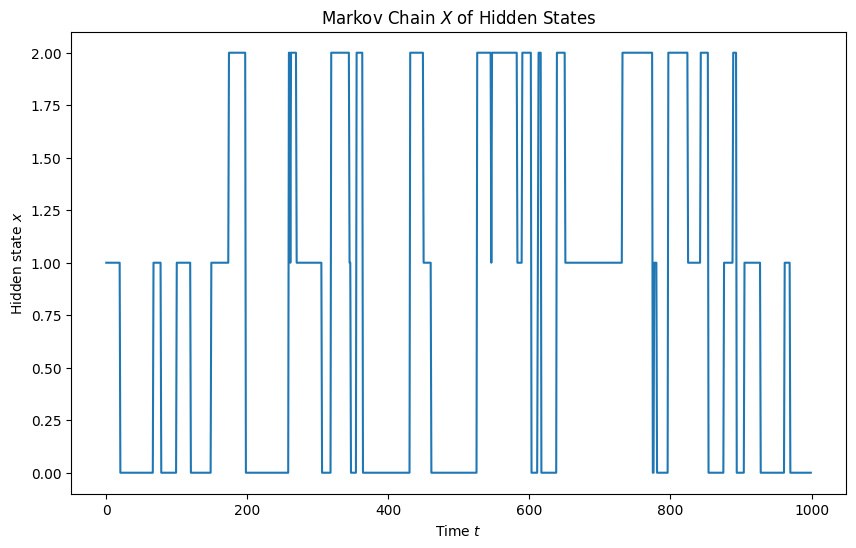

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(HMM.true_x)
plt.title('Markov Chain $X$ of Hidden States')
plt.xlabel('Time $t$')
plt.ylabel('Hidden state $x$')
plt.show()

### Markov Chain $Y$ of Observations
The Markov chain $Y$ of observations is normally distributed with parameters depending on the state of the unobserved process $X$:

$$y_t = f(x_t \vert \mu_{x_t}, \sigma_{x_t}) \quad \forall t \in [0, T]$$

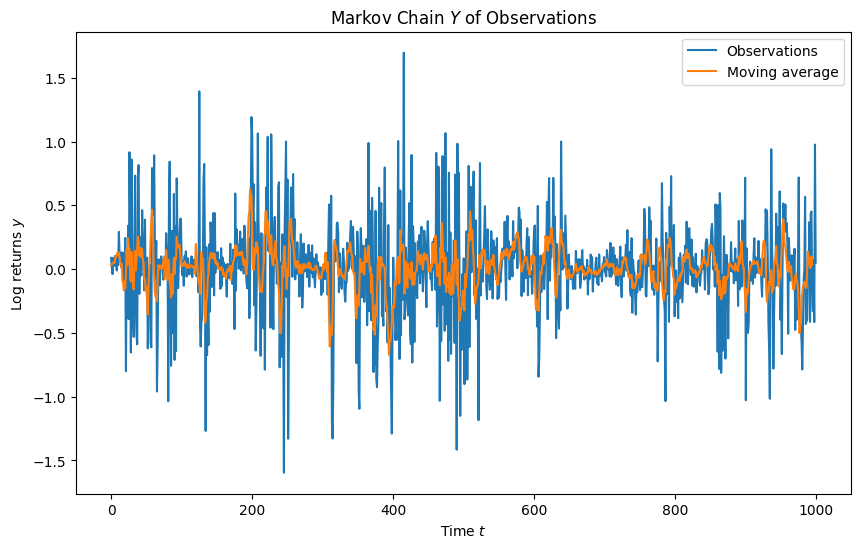

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(HMM.true_y, label='Observations')
plt.plot(HMM.true_z, label='Moving average')
plt.title('Markov Chain $Y$ of Observations')
plt.xlabel('Time $t$')
plt.ylabel('Log returns $y$')
plt.legend(loc=1)
plt.show()

### Histogram of the data
Then, we vizualize the data by plotting its histogram.

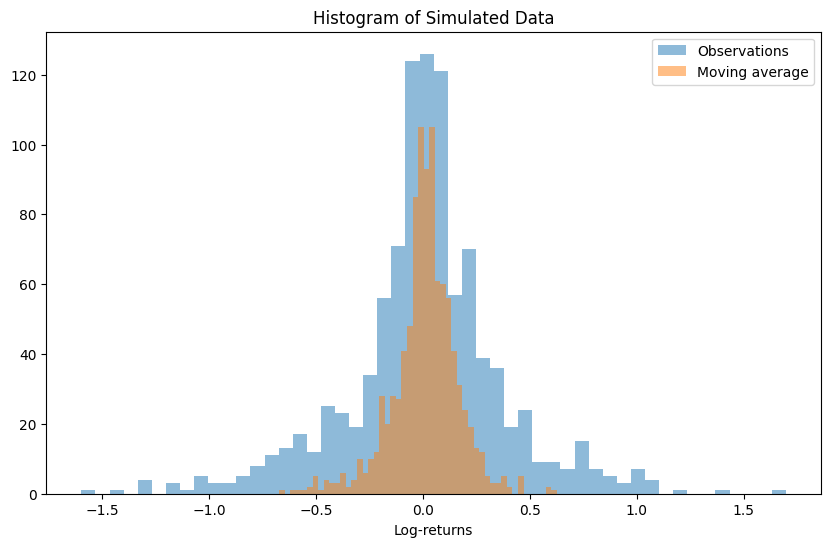

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(HMM.true_y, bins=50, alpha=.5, label='Observations')
plt.hist(HMM.true_z, bins=50, alpha=.5, label='Moving average')
plt.title('Histogram of Simulated Data')
plt.xlabel('Log-returns')
plt.legend(loc=1)
plt.show()

### Price Trajectories
Finally, from the returns, we can calculate the resulting price trajectories.

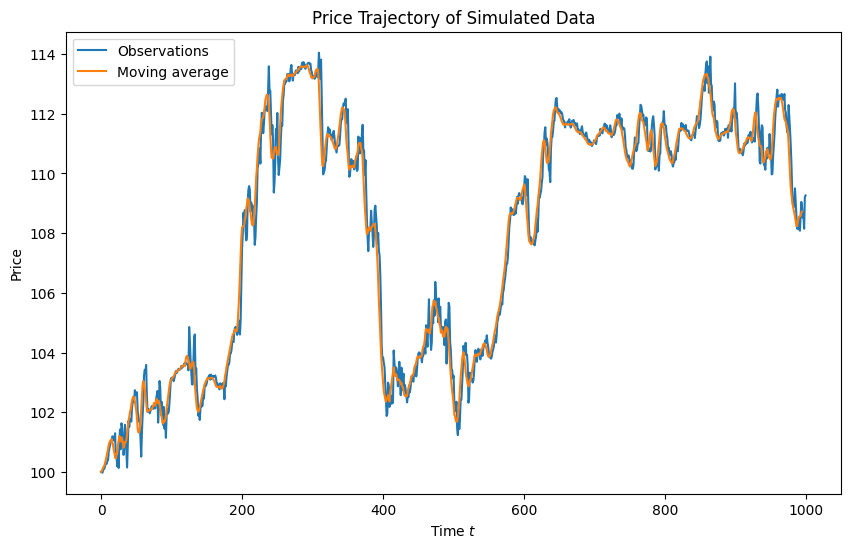

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(compute_price(HMM.true_y/100, log=True), label='Observations')
plt.plot(compute_price(HMM.true_z/100, log=True), label='Moving average')
plt.title('Price Trajectory of Simulated Data')
plt.ylabel('Price')
plt.xlabel('Time $t$')
plt.legend(loc=2)
plt.show()

## Gibbs Sampling and Parameter Estimation
This part performs Gibbs sampling to estimate parameters. `n_iter` and `n_burnin` are set for the number of iterations and burn-in period, respectively.

The Gibbs sampler consist in alternating the estimation and updating of the parameters of the model conditionally with the observations and the latent states and the estimation and updating of the unobserved Markov chain conditionally with the observations and the parameters of the model.

### HMM

In [10]:
g = gibbs(K, 0, train_test_split, HMM.true_y)
n_iter, n_burnin = 1500, 500
g.algorithm_est_ma(n_iter, n_burnin)   

  0%|          | 0/1500 [00:00<?, ?it/s]

### LMA-HMM

In [14]:
g_lma = gibbs(K, L, train_test_split, HMM.true_y)
n_iter, n_burnin = 1500, 500
g_lma.algorithm_est_ma(n_iter, n_burnin)   

  0%|          | 0/1500 [00:00<?, ?it/s]

### Parameters Estimation Results
We compare the estimated and true parameters ($M$, $\Sigma$, $\nu$, $Q$)

In [15]:
plt.subplots(figsize=(30,20))
plt.subplot(2,3,1)
plt.plot([g.res[k]['M'] for k in g.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('M')

plt.subplot(2,3,2)
plt.plot([g.res[k]['Σ'] for k in g.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('Σ')

plt.subplot(2,3,3)
plt.plot([g.res[k]['ν'] for k in g.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('ν')

for i in range(K):
    plt.subplot(2,3,4+i)
    plt.plot(np.array([g.res[k]['Q'] for k in g.res.keys()])[:,i])
    plt.legend([f'Regime {i+1}' for i in range(K)])
    plt.title(f'Q_{i+1}')
plt.show()


plt.subplots(figsize=(30,20))
plt.subplot(2,3,1)
plt.plot([g_lma.res[k]['M'] for k in g_lma.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('M')

plt.subplot(2,3,2)
plt.plot([g_lma.res[k]['Σ'] for k in g_lma.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('Σ')

plt.subplot(2,3,3)
plt.plot([g_lma.res[k]['ν'] for k in g_lma.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('ν')

for i in range(K):
    plt.subplot(2,3,4+i)
    plt.plot(np.array([g_lma.res[k]['Q'] for k in g_lma.res.keys()])[:,i])
    plt.legend([f'Regime {i+1}' for i in range(K)])
    plt.title(f'Q_{i+1}')
plt.show()

In [16]:
print('True M :', M)
print('Est. M (HMM) :', np.mean(np.array([g.res[k]['M'] for k in g.res.keys()]), axis=0))
print('Est. M (LMA-HMM):', np.mean(np.array([g_lma.res[k]['M'] for k in g_lma.res.keys()]), axis=0))

print('\nTrue Σ :', Σ)
print('Est. Σ (HMM) :', np.mean(np.array([g.res[k]['Σ'] for k in g.res.keys()]), axis=0))
print('Est. Σ (LMA-HMM):', np.mean(np.array([g_lma.res[k]['Σ'] for k in g_lma.res.keys()]), axis=0))

print('\nTrue Q :', Q)
print('Est. Q (HMM) :', np.mean(np.array([g.res[k]['Q'] for k in g.res.keys()]), axis=0))
print('Est. Q (LMA-HMM):', np.mean(np.array([g_lma.res[k]['Q'] for k in g_lma.res.keys()]), axis=0))

print('\nTrue ν :', ν)
print('Est. ν (HMM) :', np.mean(np.array([g.res[k]['ν'] for k in g.res.keys()]), axis=0))
print('Est. ν (LMA-HMM):', np.mean(np.array([g_lma.res[k]['ν'] for k in g_lma.res.keys()]), axis=0))

True M : [-0.02  0.    0.05]
Est. M (HMM) : [-0.02763356  0.00043722  0.08278938]
Est. M (LMA-HMM): [-0.232997    0.01963782  0.2545453 ]

True Σ : [0.5 0.1 0.2]
Est. Σ (HMM) : [0.0985145  0.56356542 0.18112105]
Est. Σ (LMA-HMM): [0.30600312 0.0813376  0.26697763]

True Q : [[0.95  0.025 0.025]
 [0.025 0.95  0.025]
 [0.025 0.025 0.9  ]]
Est. Q (HMM) : [[0.90989703 0.03691613 0.05318685]
 [0.00835965 0.94806838 0.04357197]
 [0.05522261 0.04721243 0.89756496]]
Est. Q (LMA-HMM): [[0.69694509 0.05910925 0.24394566]
 [0.28199427 0.41983833 0.2981674 ]
 [0.24503647 0.07443052 0.680533  ]]

True ν : [0.05 0.9  0.05]
Est. ν (HMM) : [0.22276533 0.45645888 0.32077579]
Est. ν (LMA-HMM): [0.40745726 0.12338383 0.4691589 ]


### Posterior Predictive Distribution
We visualize the posterior predictive distribution, which is the probability distribution that estimates future observations based on both the observed data and the uncertainty in model parameters in Bayesian statistics. It combines information from the data (observations) and the model (LMA-HMM) to provide a range of possible future outcomes.

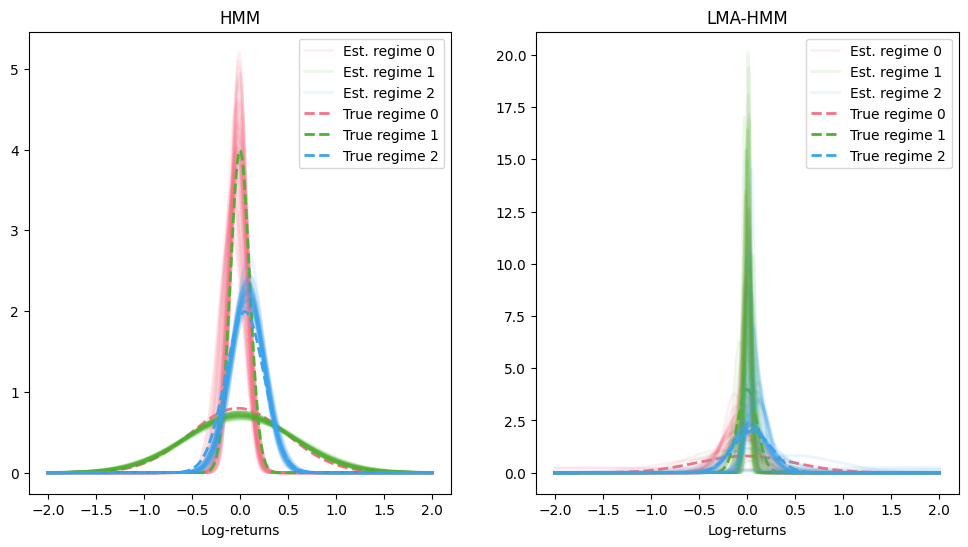

In [19]:
palette = sns.color_palette("husl", 3)
x_pdf = np.arange(-2, 2, 0.0001)

fig, ax = plt.subplots(figsize=(12,6))

plt.subplot(1, 2, 1)
for k in range(K):
    for key in list(g.res.keys())[-50:]:
        plt.plot(x_pdf, norm.pdf(x_pdf, g.res[key]['M'][k], g.res[key]['Σ'][k]), color=palette[k], linewidth=2, label='Est. regime ' + str(k), alpha=0.1)    
    plt.plot(x_pdf, norm.pdf(x_pdf, M[k], Σ[k]), '--', color=palette[k], linewidth=2, label='True regime ' + str(k))    
plt.title('HMM')
plt.xlabel('Log-returns')
legend_entries = np.append([plt.Line2D([0], [0], color=palette[k], lw=2, alpha=0.1) for k in range(K)], [plt.Line2D([0], [0], color=palette[k], lw=2, linestyle='--') for k in range(K)])
plt.legend(legend_entries, np.append(['Est. regime ' + str(k) for k in range(K)],['True regime ' + str(k) for k in range(K)]))

plt.subplot(1, 2, 2)
for k in range(K):
    for key in list(g_lma.res.keys())[-50:]:
        plt.plot(x_pdf, norm.pdf(x_pdf, g_lma.res[key]['M'][k], g_lma.res[key]['Σ'][k]), color=palette[k], linewidth=2, label='Est. regime ' + str(k), alpha=0.1)    
    plt.plot(x_pdf, norm.pdf(x_pdf, M[k], Σ[k]), '--', color=palette[k], linewidth=2, label='True regime ' + str(k))    
plt.title('LMA-HMM')
plt.xlabel('Log-returns')
legend_entries = np.append([plt.Line2D([0], [0], color=palette[k], lw=2, alpha=0.1) for k in range(K)], [plt.Line2D([0], [0], color=palette[k], lw=2, linestyle='--') for k in range(K)])
plt.legend(legend_entries, np.append(['Est. regime ' + str(k) for k in range(K)],['True regime ' + str(k) for k in range(K)]))
plt.show()

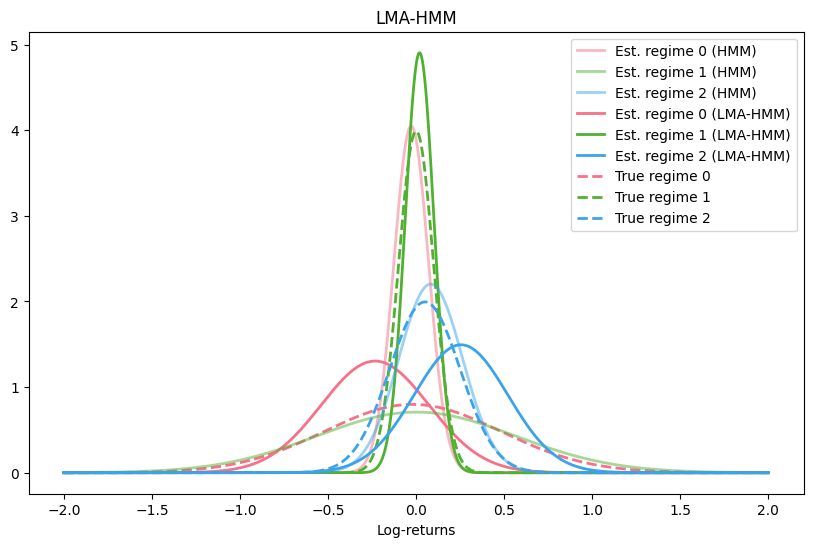

In [20]:
palette = sns.color_palette("husl", 3)
x_pdf = np.arange(-2, 2, 0.0001)

fig, ax = plt.subplots(figsize=(10,6))

for k in range(K):
    plt.plot(x_pdf, norm.pdf(x_pdf, np.mean(np.array([g.res[k]['M'] for k in g.res.keys()]), axis=0)[k], np.mean(np.array([g.res[k]['Σ'] for k in g.res.keys()]), axis=0)[k]), color=palette[k], linewidth=2, label='Est. regime ' + str(k) + ' (HMM)', alpha=0.5)    
    plt.plot(x_pdf, norm.pdf(x_pdf, np.mean(np.array([g_lma.res[k]['M'] for k in g_lma.res.keys()]), axis=0)[k], np.mean(np.array([g_lma.res[k]['Σ'] for k in g_lma.res.keys()]), axis=0)[k]), color=palette[k], linewidth=2, label='Est. regime ' + str(k) + ' (HMM)', alpha=1)    
    plt.plot(x_pdf, norm.pdf(x_pdf, M[k], Σ[k]), '--', color=palette[k], linewidth=2, label='True regime ' + str(k))    
plt.title('LMA-HMM')
plt.xlabel('Log-returns')
legend_entries = np.append(np.append([plt.Line2D([0], [0], color=palette[k], lw=2, alpha=0.5) for k in range(K)], [plt.Line2D([0], [0], color=palette[k], lw=2, alpha=1) for k in range(K)]), [plt.Line2D([0], [0], color=palette[k], lw=2, linestyle='--') for k in range(K)])
plt.legend(legend_entries, np.append(np.append(['Est. regime ' + str(k) + ' (HMM)' for k in range(K)], ['Est. regime ' + str(k) + ' (LMA-HMM)' for k in range(K)]),['True regime ' + str(k) for k in range(K)]))
plt.show()

### State Decoding Results
This section visualizes the results of the states decoding:
* the **in-sample decoding**, in the training period
* the **out-of-sample decoding**, in the test period

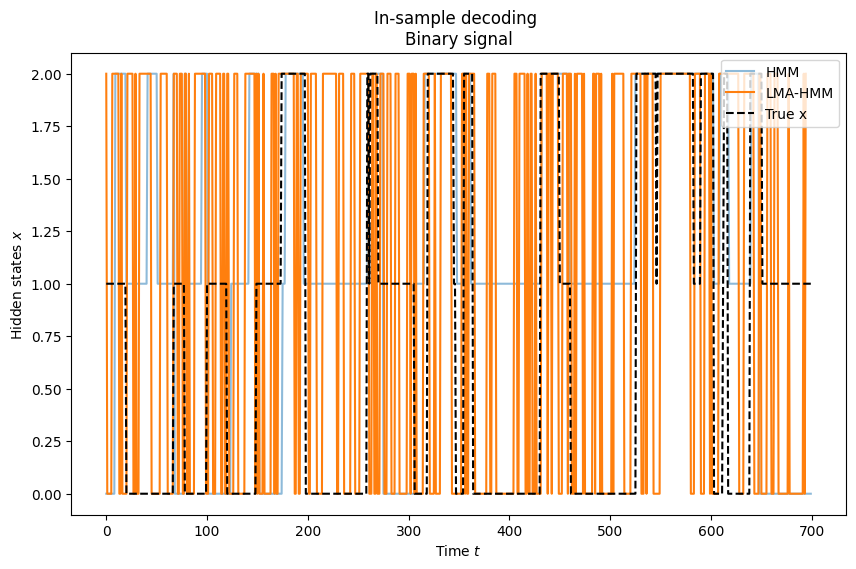

In-sample accuracy (HMM):0.24
In-sample accuracy (LMA-HMM):0.42


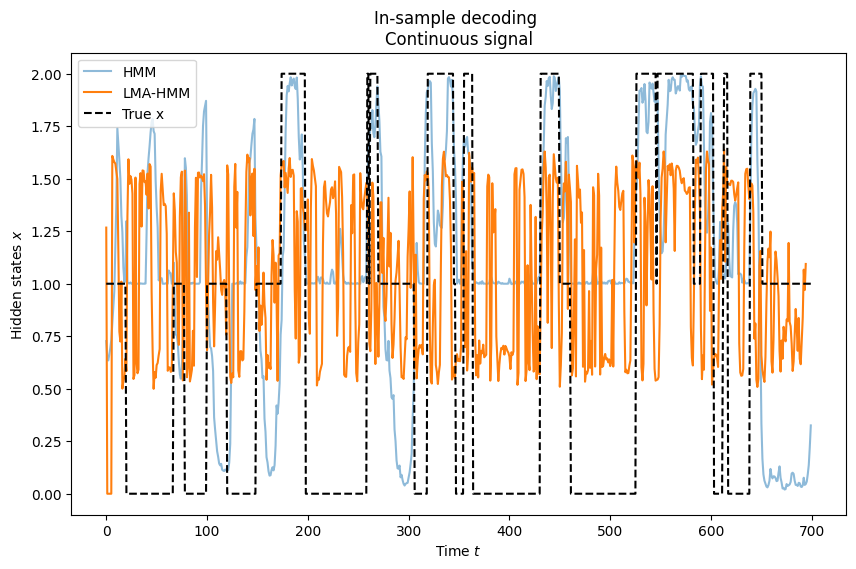

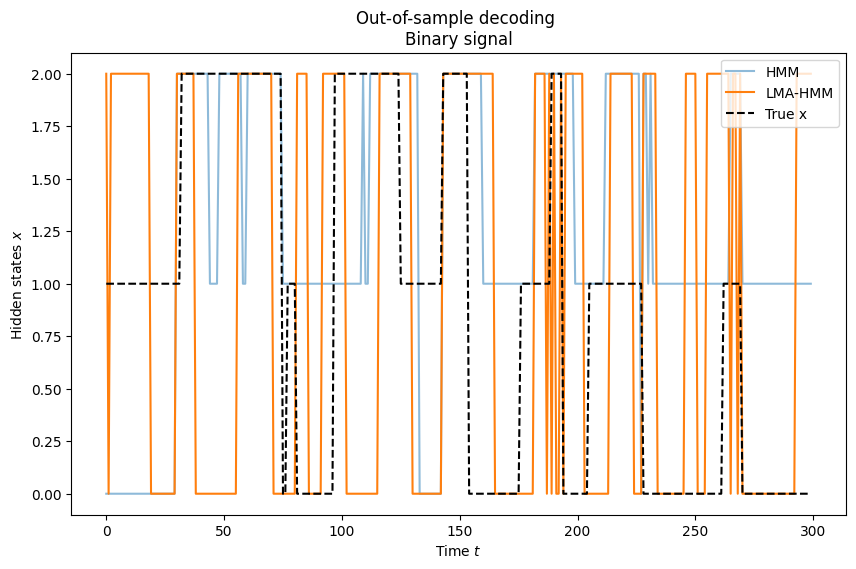

Out-of-sample accuracy (HMM):0.29
Out-of-sample accuracy (LMA-HMM):0.36


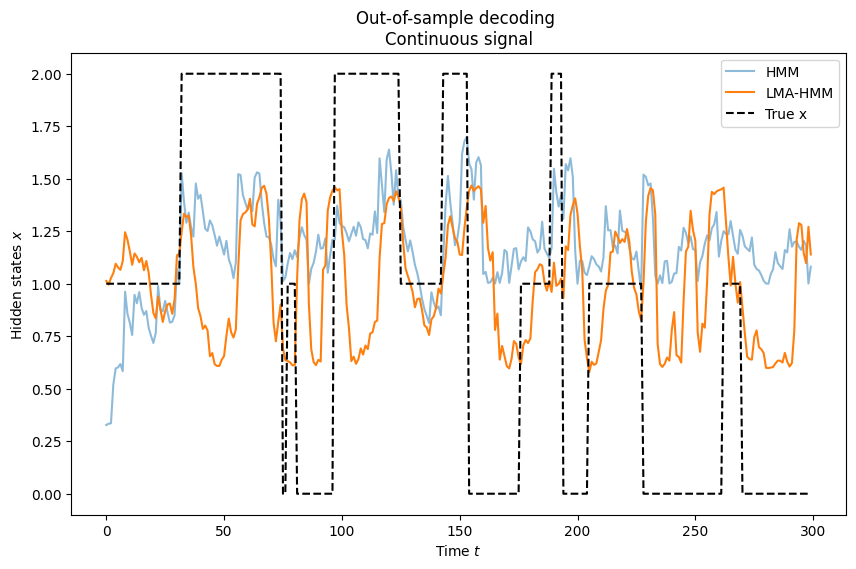

In [21]:
x_all_is = np.array([g.res[k]['x_is'] for k in g.res.keys()])
x_is = np.array([np.argmax(np.bincount(column)) for column in x_all_is.T.astype(int)])
x_is_cont = np.mean(x_all_is, axis=0)

x_all_is_lma = np.array([g_lma.res[k]['x_is'] for k in g_lma.res.keys()])
x_is_lma = np.array([np.argmax(np.bincount(column)) for column in x_all_is_lma.T.astype(int)])
x_is_lma_cont = np.mean(x_all_is_lma, axis=0)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_is, label='HMM', alpha=.5)
plt.plot(x_is_lma, label='LMA-HMM', alpha=1)
plt.plot(HMM.true_x_is, '--', label='True x', alpha=1, color='black')
plt.title('In-sample decoding \nBinary signal')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.legend(loc=1)
plt.show()
print('In-sample accuracy (HMM):' + str(np.round(len(x_is[x_is == HMM.true_x_is])/len(x_is), 2)))
print('In-sample accuracy (LMA-HMM):' + str(np.round(len(x_is_lma[x_is_lma == HMM.true_x_is[HMM.L:]])/len(x_is_lma), 2)))

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_is_cont, label='HMM', alpha=.5)
plt.plot(x_is_lma_cont, label='LMA-HMM', alpha=1)
plt.plot(HMM.true_x_is, '--', label='True x', alpha=1, color='black')
plt.title('In-sample decoding \nContinuous signal')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.legend(loc=2)
plt.show()

x_all_oos = np.array([g.res[k]['x_oos'][-len(HMM.true_x_oos):] for k in g.res.keys()])
x_oos = np.array([np.argmax(np.bincount(column)) for column in x_all_oos.T.astype(int)])
x_oos_cont = np.mean(x_all_oos, axis=0)

x_all_oos_lma = np.array([g_lma.res[k]['x_oos'][-len(HMM.true_x_oos):] for k in g_lma.res.keys()])
x_oos_lma = np.array([np.argmax(np.bincount(column)) for column in x_all_oos_lma.T.astype(int)])
x_oos_lma_cont = np.mean(x_all_oos_lma, axis=0)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_oos, label='HMM', alpha=.5)
plt.plot(x_oos_lma, label='LMA-HMM', alpha=1)
plt.plot(HMM.true_x_oos, '--', label='True x', alpha=1, color='black')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.title('Out-of-sample decoding \nBinary signal')
plt.legend(loc=1)
plt.show()
print('Out-of-sample accuracy (HMM):' + str(np.round(len(x_oos[x_oos == HMM.true_x_oos])/len(x_oos), 2)))
print('Out-of-sample accuracy (LMA-HMM):' + str(np.round(len(x_oos_lma[x_oos_lma == HMM.true_x_oos])/len(x_oos_lma), 2)))

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_oos_cont, label='HMM', alpha=.5)
plt.plot(x_oos_lma_cont, label='LMA-HMM', alpha=1)
plt.plot(HMM.true_x_oos, '--', label='True x', alpha=1, color='black')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.title('Out-of-sample decoding \nContinuous signal')
plt.legend(loc=1)
plt.show()